In [15]:
from ROOT import TFile
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import mplhep as hep
import ipywidgets as widget
import scipy
from scipy import stats

In this notebook, we evaluate how the various inputs associated with the $b$-tag analyzer vary with the difference in RECO and GEN PV z distance ($\Delta z(\mathrm{GEN\ PV,RECO\ PV})$).  These inputs are also used when deriving scale factors and viewing the input distributions can provide insight into why the scale factors derived at a certain phase space of $\Delta z(\mathrm{GEN\ PV,RECO\ PV})$ does not extend well into other regions of the phase space.

In [18]:
filenames = [
    "Semilepton_HT500Njet9_2017_17k_mc.root",
    "Semilepton_HT500Njet9_2017_23k_mc.root",
    "Semilepton_HT500Njet9_2017_28k_mc.root"
]
lumitext = "Semilepton_HT500Njet9"
year = "2017"
rFiles = { filename: TFile.Open( filename ) for filename in filenames } 
rTrees = { filename: rFiles[ filename ].Get( "btagana" ).Get( "ttree" ) for filename in filenames }
savedir = "./{}_{}".format( lumitext, year )
if not os.path.exists( savedir ):
    os.mkdir( savedir )
total_events = 0
for filename in filenames:
    print( ">> {} has {} events".format( filename, rTrees[ filename ].GetEntries() ) )
    total_events += rTrees[ filename ].GetEntries() 
print( ">> Total Events: {}".format( total_events ) )

>> Semilepton_HT500Njet9_2017_17k_mc.root has 17100 events
>> Semilepton_HT500Njet9_2017_23k_mc.root has 22500 events
>> Semilepton_HT500Njet9_2017_28k_mc.root has 28159 events
>> Total Events: 67759


## Plotting parameters
The following parameters determine how each variable is stored in histogram as well as plotted.  `BINS` is a `np.linspace()` object describing the minimum, maximum and number of bins to be plotted. `SCHEME` refers to how the variables should be accessed from the `ROOT` file because some are stored as `long` values (1), single-entry arrays (2) or arrays (3).

In [19]:
plot_params = {
    "Jet_DeepCSVb": { "BINS": np.linspace(0,1,51), "SCHEME": 3, "LATEX": "\mathrm{deepCSV}\ \mathrm{P}(b)" },
    "Jet_DeepCSVbb": { "BINS": np.linspace(0,1,51), "SCHEME": 3, "LATEX": "\mathrm{deepCSV}\ \mathrm{P}(bb)" },
    "Jet_eta": { "BINS": np.linspace(-2.8,2.8,51), "SCHEME": 3, "LATEX": "Jet\ \eta" },
    "Jet_pt": { "BINS": np.linspace(20,250,24), "SCHEME": 3, "LATEX": "Jet\ p_T" },
    "PV_x": { "BINS": np.linspace(-0.06,0.05,31), "SCHEME": 2, "LATEX": "x_{PV}" },
    "PV_y": { "BINS": np.linspace(0.02,0.12,31), "SCHEME": 2, "LATEX": "y_{PV}" },
    "PV_z": { "BINS": np.linspace(-20,20,51), "SCHEME": 2, "LATEX": "z_{PV}" },
    "PV_chi2": { "BINS": np.linspace(0,30,31), "SCHEME": 3, "LATEX": "\chi^2_{PV}" },
    "SV_EnergyRatio": { "BINS": np.linspace(0,20,21), "SCHEME": 3, "LATEX": "E_{SV}\ /\ E_{Jet}" },
    "SV_chi2": { "BINS": np.linspace(0,30,31), "SCHEME": 3, "LATEX": "\chi^2_{SV}" },
    "SV_flight": { "BINS": np.linspace(0,6,25), "SCHEME": 3, "LATEX": "SV\ 3D\ Flight\ Distance" },
    "SV_mass": { "BINS": np.linspace(0,7,29), "SCHEME": 3, "LATEX": "M_{SV}" },
    "SV_nTrk": { "BINS": np.linspace(0,15,16), "SCHEME": 3, "LATEX": "SV\ N_{track}" },
    "SV_vtxDistJetAxis": { "BINS": np.linspace(0,0.00015,16), "SCHEME": 3, "LATEX": "\Delta d(SV,Jet\ Axis)" },
    "SV_vtx_eta": { "BINS": np.linspace(-2.5,2.5,31), "SCHEME": 3, "LATEX": "SV\ \eta" },
    "SV_vtx_pt": { "BINS": np.linspace(0,300,31), "SCHEME": 3, "LATEX": "SV\ p_T" },
    "SV_x": { "BINS": np.linspace(0,2.5,21), "SCHEME": 3, "LATEX": "x_{SV}" },
    "SV_y": { "BINS": np.linspace(0,2.5,21), "SCHEME": 3, "LATEX": "y_{SV}" },
    "SV_z": { "BINS": np.linspace(-15,18,31), "SCHEME": 3, "LATEX": "z_{SV}" },
    "TagVarCSV_flightDistance2dSig": { "BINS": np.linspace(0,800,51), "SCHEME": 3, "LATEX": "Sig.\ \Delta d_T(PV,SV)" },
    "TagVarCSV_jetNSecondaryVertices": { "BINS": np.linspace(0,6,7), "SCHEME": 3, "LATEX": "Jet\ N_{SV}" },
    "TagVarCSV_jetNTracks": { "BINS": np.linspace(0,21,22), "SCHEME": 3, "LATEX": "Jet\ N_{tracks}" },
    "TagVarCSV_trackDecayLenVal": { "BINS": np.linspace(0,5,11), "SCHEME": 3, "LATEX": "Track\ Decay\ Length" }, # not sure about this label
    "TagVarCSV_trackDeltaR": { "BINS": np.linspace(0,0.3,31), "SCHEME": 3, "LATEX": "\Delta r(track,jet\ axis)" }, # not sure about this label
    "TagVarCSV_trackPtRatio": { "BINS": np.linspace(0,0.3,31), "SCHEME": 3, "LATEX": "Track\ p_T^{rel}\ / Track\ E"  }, # not sure about this label
    "TagVarCSV_trackPtRel": { "BINS": np.linspace(0,30,31), "SCHEME": 3, "LATEX": "Track\ p_T^{rel}" },
    "TagVarCSV_trackSip2dSigAboveCharm": { "BINS": np.linspace(0,30,31), "SCHEME": 3, "LATEX": "Sig.\ Track\ 2D\ SIP(Track\ >M_c)" },
    "TagVarCSV_trackSumJetDeltaR": { "BINS": np.linspace(0,4,41), "SCHEME": 3, "LATEX": "\Delta r(\Sigma track,j)" },
    "TagVarCSV_trackSumJetEtRatio": { "BINS": np.linspace(0,4,41), "SCHEME": 3, "LATEX": "\Sigma E^{track}_T\ /\ E^{j}" },
    "TagVarCSV_vertexEnergyRatio": { "BINS": np.linspace(0,30,31), "SCHEME": 3, "LATEX": "E^{SV}\ /\ E^{j}" },
    "TagVarCSV_vertexJetDeltaR": { "BINS": np.linspace(0,0.3,31), "SCHEME": 3, "LATEX": "\Delta r(SV,j)" },
    "TagVarCSV_vertexNTracks": { "BINS": np.linspace(0,21,22), "SCHEME": 3, "LATEX": "SV\ N_{tracks}" },
    "nJet": { "BINS": np.linspace(0,15,16), "SCHEME": 1, "LATEX": "N_j" },
    "nPV": { "BINS": np.linspace(0,122,62), "SCHEME": 1, "LATEX": "N_{PV}" },
    "nSV": { "BINS": np.linspace(0,11,12), "SCHEME": 1, "LATEX": "N_{SV}" },
    "nTrkTagVarCSV": { "BINS": np.linspace(0,84,43), "SCHEME": 1, "LATEX": "SV\ N_{track}" }
}

### 2D Histogram Plot Format Parameters
Plotting parameters for scaling the plot figure and labels based on the sample dimensions being plotted. The parameters are as follows:  
* `fig`: multiplicative scaling for the figure size based on the size of the histogram dimensions
* `textsize`: textsize for the title, x-axis and y-axis labels
* `table`: the x- and y-table scaling size to fit the figure dimensions
* `cbar`: the 2D histogram colorbar shrink size
* `shift`: the x-ticks and y-ticks coordinate shift to accomodate tables

In [20]:
plot_yscale = {
    4:  { "fig": 2 ,"textsize": 14, "table": [(1,1.6),(0.06,7.45)], "cbar": 0.8 , "shift": [-0.07,-0.07] },
    5:  { "fig": 2 ,"textsize": 14, "table": [(1,1.6),(0.06,7.45)], "cbar": 0.8 , "shift": [-0.07,-0.07] },
    6:  { "fig": 10/6 ,"textsize": 14, "table": [(1,1.6),(0.06,6.15)], "cbar": 0.8 , "shift": [-0.07,-0.07] },
    7:  { "fig": 10/7 ,"textsize": 14, "table": [(1,1.6),(0.05,5.30)], "cbar": 0.8 , "shift": [-0.07,-0.07] },
    8:  { "fig": 10/8 ,"textsize": 16, "table": [(1,1.6),(0.06,4.65)], "cbar": 0.8 , "shift": [-0.07,-0.05] },
    9:  { "fig": 12/9 ,"textsize": 16, "table": [(1,1.6),(0.04,4.40)], "cbar": 0.85 , "shift": [-0.07,-0.05] },
    10: { "fig": 12/10 ,"textsize": 20, "table": [(1,1.6),(0.04,4.45)], "cbar": 0.85 , "shift": [-0.05,-0.05] },
    11: { "fig": 14/11 ,"textsize": 20, "table": [(1,1.6),(0.04,4.75)], "cbar": 0.85 , "shift": [-0.07,-0.05] },
    12: { "fig": 14/12 ,"textsize": 20, "table": [(1,1.6),(0.04,4.35)], "cbar": 0.85 , "shift": [-0.07,-0.05] },
    13: { "fig": 14/13 ,"textsize": 22, "table": [(1,1.6),(0.04,4.00)], "cbar": 0.85 , "shift": [-0.07,-0.05] },
    14: { "fig": 15/14 ,"textsize": 22, "table": [(1,1.6),(0.03,3.98)], "cbar": 0.85 , "shift": [-0.05,-0.05] },
    15: { "fig": 16/15 ,"textsize": 22, "table": [(1,1.6),(0.03,3.98)], "cbar": 0.80 , "shift": [-0.04,-0.04] },
    16: { "fig": 17/16 ,"textsize": 22, "table": [(1,1.6),(0.03,3.95)], "cbar": 0.80 , "shift": [-0.04,-0.04] },
    17: { "fig": 1 ,"textsize": 22, "table": [(1,1.6),(0.03,3.72)], "cbar": 0.80 , "shift": [-0.04,-0.04] },
    18: { "fig": 20/18 ,"textsize": 24, "table": [(1,1.6),(0.03,4.14)], "cbar": 0.80 , "shift": [-0.04,-0.04] },
    19: { "fig": 21/19, "textsize": 24, "table": [(1,1.6),(0.03,4.04)], "cbar": 0.80, "shift": [-0.04,-0.04] },
    20: { "fig": 22/20, "textsize": 25, "table": [(1,1.6),(0.03,4.04)], "cbar": 0.80, "shift": [-0.04,-0.04] },
    21: { "fig": 23/21, "textsize": 25, "table": [(1,1.6),(0.03,4.08)], "cbar": 0.80, "shift": [-0.03,-0.04] }
}

### Determine the $\Delta z$ for the GEN and RECO PV

In [21]:
dz_bins = 5

branches = [ branch.GetName() for branch in rTrees[ list( rTrees.keys() )[0] ].GetListOfBranches() ]

dz_per_event = { i: 0 for i in range( total_events ) }
dz_list = []
z_RECO = []
z_GEN = []
max_dz = 0

evt = 0 
for filename in filenames:
    rTree = rTrees[ filename ]
    for i in range( rTree.GetEntries() ):
        rTree.GetEntry(i)
        z_RECO_ = getattr( rTree, "PV_z" )[0] 
        z_GEN_ = getattr( rTree, "GenPVz" )

        dz_per_event[evt] = abs( z_RECO_ - z_GEN_ )
        dz_list.append( dz_per_event[evt] )
        if dz_per_event[evt] > max_dz: max_dz = dz_per_event[evt]
        z_RECO.append( z_RECO_ )
        z_GEN.append( z_GEN_ )
        evt += 1

In [22]:
variable = widget.Dropdown( options = sorted( [ branch for branch in branches ] ) )
variable

Dropdown(options=('GenPVz', 'Jet_DeepCSVb', 'Jet_DeepCSVbb', 'Jet_eta', 'Jet_pt', 'PV_chi2', 'PV_x', 'PV_y', '…

### Populate the selected variable histogram

In [23]:
hist = { i: [] for i in range( dz_bins ) }
edges = np.linspace(0,0.003,dz_bins+1)

max_val = 0
evt = 0

for filename in filenames:
    rTree = rTrees[ filename ]
    for i in range( rTree.GetEntries() ):
        rTree.GetEntry(i)
        dz = dz_per_event[evt]
        attribute = getattr( rTree, variable.value )

        for j in range( dz_bins ):
            if ( dz >= edges[j] ) & ( dz < edges[j+1] ):
                if plot_params[ variable.value ][ "SCHEME" ] == 1:
                    hist[ j ].append( attribute )
                    if attribute > max_val: max_val = attribute

                elif plot_params[ variable.value ][ "SCHEME" ] == 2:
                    hist[ j ].append( attribute[0] )
                    if attribute[0] > max_val: max_val = attribute[0]

                elif plot_params[ variable.value ][ "SCHEME" ] == 3:
                    for k, value in enumerate( attribute ):
                        hist[ j ].append( value )
                        if value > max_val: max_val = value
        evt += 1

### Plot the $\Delta z$ Histograms

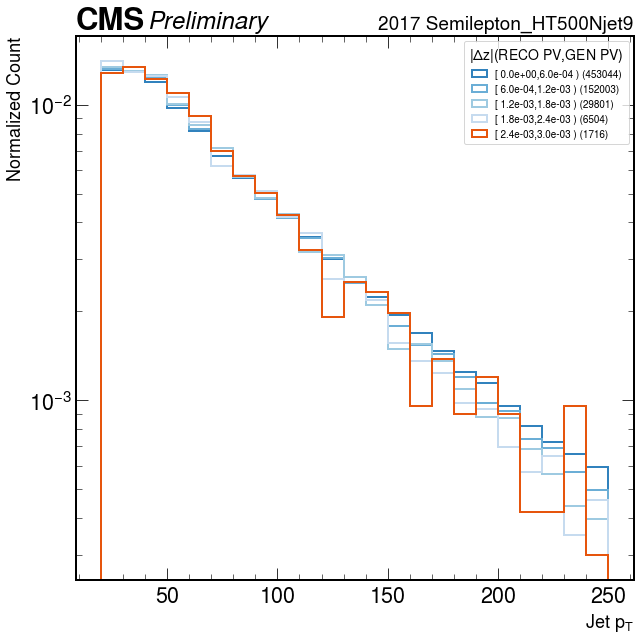

In [24]:
hide = []
plt.style.use( hep.style.CMS )
plt.figure( figsize = (10,10) )
c = 0
for i in hist:
    if i in hide: continue
    plt.hist(
        hist[i], bins = plot_params[ variable.value ][ "BINS" ], label = "[ {:.1e},{:.1e} ) ({})".format( edges[i], edges[i+1], len( hist [i] ) ),
        density = True, alpha = 1.0, histtype = "step", linewidth = 2, color = cm.tab20c.colors[ c ]
    )
    c += 1
hep.cms.text( "Preliminary", fontsize = 24 )
hep.cms.lumitext( "{} {}".format( year, lumitext ), fontsize = 20 )
plt.ylabel( "Normalized Count", y = 1.0, ha = "right", fontsize = 18 )
plt.yscale( "log" )
plt.xlabel( "${}$".format( plot_params[ variable.value ][ "LATEX" ] ), x = 1.0, ha = "right", fontsize = 18 )
plt.legend( title = "$|\Delta z|$(RECO PV,GEN PV)", title_fontsize = 14, loc = "best", fontsize = 10, frameon = True, framealpha = 0.8, borderpad = 0.5 )
plt.savefig( "{}/{}".format( savedir, "{}_dz_HIST_{}.png".format( filename, variable.value ) ) )
plt.show()
plt.close()

### Calculate the Kolmogorov-Smirnov Statistic for $\Delta z$ vs $\Delta z$ Histograms

In [25]:
p_ks = np.zeros( ( dz_bins, dz_bins ) )

alpha = 0.5

for x in range( dz_bins ):
    for y in range( dz_bins ):
        if hist[x] == [] or hist[y] == []: continue
        else: _, p_ks[x][y] = stats.ks_2samp( hist[x], hist[y] )

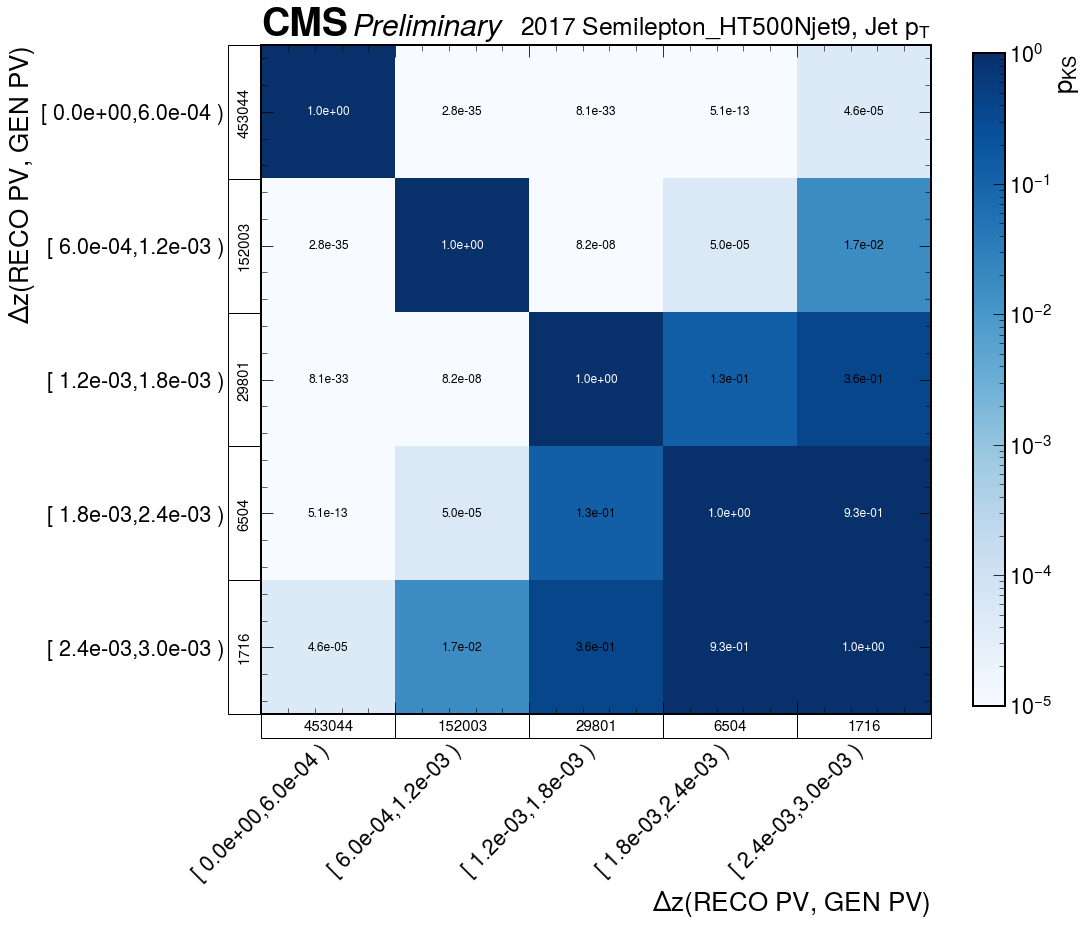

In [26]:
plt.figure( figsize = ( dz_bins*3, dz_bins*3 ) )
plt.imshow( p_ks, cmap="Blues", norm = colors.LogNorm( vmin = 1e-5, vmax = 1.0 ) )
plt.colorbar( label = "$p_{KS}$", shrink = 0.8 )
for x in range( dz_bins ):
    for y in range( dz_bins ):
        color = "white" if p_ks[x][y] > alpha else "black"
        plt.text(
            x, y, "{:.1e}".format( p_ks[x][y] ),
            ha = "center", va = "center", fontsize = 12, color = color
        )
hep.cms.text( "Preliminary", fontsize = 30 )
hep.cms.lumitext( "{} {}, ${}$".format( year, lumitext, plot_params[ variable.value ][ "LATEX" ] ) )
plt.xlabel( "$\Delta z$(RECO PV, GEN PV)" )
plt.xticks(
    ticks = [ bin_ - 0.5 for bin_ in range( dz_bins ) ],
    labels = [ "[ {:.1e},{:.1e} )".format( edges[i], edges[i+1] ) for i in range( dz_bins ) ],
    rotation = 45, y = -0.03
)
xtable = plt.table(
    cellText = [ [ str( len( hist[i] ) ) for i in hist ] ],
    loc = "bottom", cellLoc = "center"
)
xtable.set_fontsize(15)
xtable.scale(1,2)
plt.ylabel( "$\Delta z$(RECO PV, GEN PV)" )
plt.yticks(
    ticks = list( range( dz_bins ) ),
    labels = [ "[ {:.1e},{:.1e} )".format( edges[i], edges[i+1] ) for i in range( dz_bins ) ],
    x = -0.05
)
ytable = plt.table(
    cellText = [ [ str( len( hist[i] ) ) ] for i in hist ],
    loc = "left", cellLoc = "center"
)
ytable.set_fontsize(15)
ytable.scale(0.05,11.15)
for key in ytable._cells:
    ytable._cells[key].set_text_props( rotation = "vertical" )
plt.savefig( "{}/{}".format( savedir, "{}_{}_dzdz_pKS.png".format( filename, variable.value ) ) )
plt.show()
plt.close()